<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<center><h1>Sistema inteligente para ayudar a detectar posibles reclamos (glosas) en las cuentas médicas previo al cobro, de una clínica en Colombia - Audimed</h1></center>
<center><h2>Trabajo Fin de Master<br>Máster Universitario en Análisis y Visualización de Datos Masivos / Visual Analytics and Big Data</h2></center>

<h3>Presentado por: Jacqueline Guzmán Rodriguez</h3>
<h4>Tipo de trabajo: Desarrollo Software <br>
Director: Juan Carlos Rincon Acuña <br>
Fecha: Junio/2024</h4>

<h3> <font color="#040078">Notebook de modelado de los datos</font></h3>
<h4></h4>
<h5><font color="#C62400">Licencia del Notebook CC BY-NC-SA 4.0 DEED <a href="https://creativecommons.org/licenses/by-nc-sa/4.0/" target="_blank]">https://creativecommons.org/licenses/by-nc-sa/4.0/</a></font></h5/>

## Importación de librerias necesarias

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
#from matplotlib import pyplot
#import matplotlib.pyplot as plt 
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

In [2]:
# Read file CSV Download of https://www.kaggle.com/datasets/d8e399cf772f115f4350cae12016ef9f497f63389a06dfdceb3292aa7fb72956
file_cvs = "claims.csv"
# Create dataframe with information of file CSV
df = pd.read_csv(file_cvs, delimiter=',', encoding='utf-8')

In [3]:
# Drop column NUM_HISTORY_MED_SET_24, because don't have data, all values is 0
df = df.drop ('NUM_HISTORY_MED_SET_24', axis = 1)

In [4]:
# Define colums target (CLAIM)
columns = df.columns
target = "CLAIM"
x_columns = columns.drop(target)

In [5]:
# Update datatype int64 to int32 and float64 to float32, because it is necessary to use less RAM
float_columns = ['QUANTITY_PRODUCT_SERVICE', 'SALES_PRICE', 'INVOICED_PRICE']
int_columns = columns.drop(float_columns)
df[float_columns]=df[float_columns].astype(np.float32)
df[int_columns]=df[int_columns].astype(int)

In [6]:
# Normalize data via MinMaxScaler function
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df,columns=columns)

In [7]:
# Distribution of the target variable
print(str(target)+':\n'+str(df[target].unique())+'\n')
print(df[target].value_counts())

CLAIM:
[0. 1.]

CLAIM
0.0    6104323
1.0        120
Name: count, dtype: int64


In [8]:
# Dividir variables de entrada y objetivo
ValX = df.drop(columns=target)
ValY = df[target]

In [9]:
# Set training and validation data
X_train, X_validation, Y_train, Y_validation = train_test_split(ValX, ValY, test_size=0.15, random_state=1, shuffle=True)

In [10]:
X_train.shape, X_validation.shape

((5188776, 53), (915667, 53))

In [11]:
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
X_train, Y_train = sm.fit_resample(X_train, Y_train)
df_train_oversampled = pd.concat([pd.DataFrame(Y_train), pd.DataFrame(X_train)], axis=1)

In [12]:
X_train.shape, X_validation.shape

((10377344, 53), (915667, 53))

In [13]:
print(str(target)+':\n'+str(df_train_oversampled[target].unique())+'\n')
print(df_train_oversampled[target].value_counts())

CLAIM:
[0. 1.]

CLAIM
0.0    5188672
1.0    5188672
Name: count, dtype: int64


In [14]:
rfc_model = RandomForestClassifier(random_state=0, n_estimators=5, max_depth=10)
rfc_model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=5, random_state=0)

In [ ]:
# Realizar la búsqueda de hiperparámetros utilizando GridSearchCV
rfc_model = RandomForestClassifier(random_state=42)
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15]}

In [15]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(rfc_model, param_grid=param_grid, cv=10, return_train_score=True)
grid_search.fit(X_train, Y_train)

NameError: name 'param_grid' is not defined

In [ ]:
# Imprimir los resultados
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print("Mejor puntuación de validación cruzada:")
print(grid_search.best_score_)

In [16]:
Y_predict = rfc_model.predict(X_validation)

In [17]:
print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(Y_validation, Y_predict)))

Model accuracy score with 10 decision-trees : 0.9861


In [18]:
print("Prediction for test set: {}".format(Y_predict))

Prediction for test set: [0. 0. 0. ... 0. 0. 0.]


In [19]:
#Crear un dataset para comprar la salida esperada con la salida de predicción
mlr_diff = pd.DataFrame({'Actual value': Y_validation, 'Predicted value': Y_predict})
mlr_diff.tail(10)

,Actual value,Predicted value
3141433,0.0,0.0
3895887,0.0,0.0
2199388,0.0,0.0
2010216,0.0,0.0
5153739,0.0,0.0
6054309,0.0,0.0
1411925,0.0,0.0
596122,0.0,0.0
5236999,0.0,0.0
4092770,0.0,0.0


<Axes: xlabel='Actual value', ylabel='Count'>

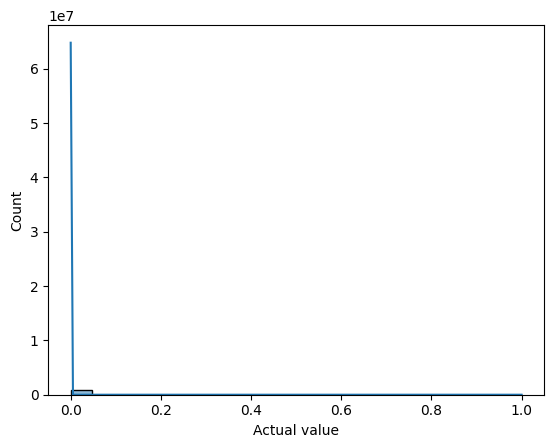

In [20]:
#Comportamiento de la salida esperada
sns.histplot(data=mlr_diff["Actual value"], kde=True)

<Axes: xlabel='Predicted value', ylabel='Count'>

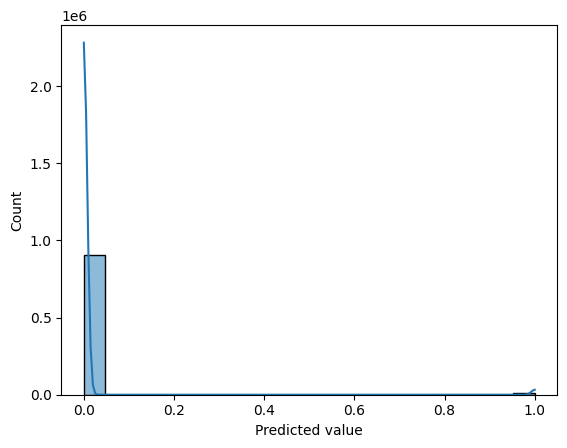

In [21]:
#Comportamientos de la Salida Predicha
sns.histplot(data=mlr_diff["Predicted value"], kde=True)

<Axes: ylabel='Count'>

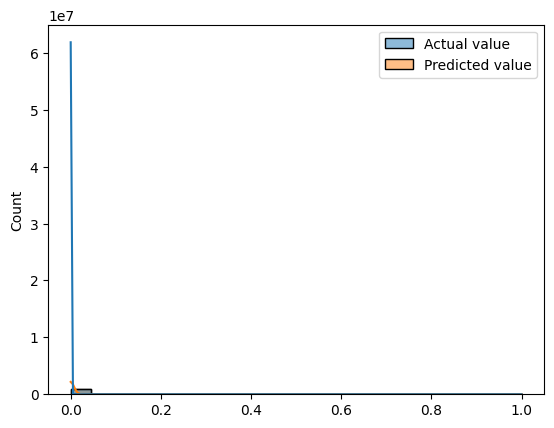

In [22]:
#Comportamiento de la salida esperada y predicha 
sns.histplot(data=mlr_diff, kde=True)

In [23]:
#Metricas de evaluación del modelo
score = rfc.score(X_train, Y_train)
mse = mean_squared_error(Y_validation, Y_predict)
print("R-squared:", score)
print("MSE: ", mse)
print("RMSE: ", mse**(1/2.0))

NameError: name 'rfc' is not defined

In [24]:
history=insurance_model.fit(X_train,Y_train,epochs=1)

NameError: name 'insurance_model' is not defined